# Spike sorting example with 'tridesclous' on dataset "Locust"

Proces steps:
 1. Catalogue construction:
   * filter and smooth the signal
   * peak detection
   * waveform cut with good limit
   * projection and clustering
   * construct catalogue
 2. Peeling
   





This is necessary for having figures directly in the notebook.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import necessary modules

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import seaborn as sns

import tridesclous as tdc

Download Locust dataset from zenedo.
Get the first trial as a standard numpy array. shape = (nb_sampleXnb_channel)

In [8]:
from urllib.request import urlretrieve
import os
import h5py

name = 'locust20010201.hdf5'
distantfile = 'https://zenodo.org/record/21589/files/'+name
localfile = name
if not os.path.exists(localfile):
    urlretrieve(distantfile, localfile)
hdf = h5py.File(localfile,'r')

#create numpy array from the first trials
ch_names = ['ch09','ch11','ch13','ch16']
numpy_sigs = np.array([hdf['Continuous_1']['trial_01'][name][...] for name in ch_names]).transpose()
#numpy_sigs = (numpy_sigs.astype('float32') - 2**15.) / 2**15


# Signals = pandas.DataFrame
Each segment of data is a pandas.DataFrame:
  * index is the time coded in second.
  * columns are channels names.



In [9]:
sampling_rate =  15000. #in Hz
t_start = 0. #this is the time of the first point in second
times = np.arange(numpy_sigs.shape[0], dtype = 'float64')/sampling_rate + t_start
signals = pd.DataFrame(numpy_sigs, index = times, columns = ch_names)

So we can acces with times or sample position with DataFrame.loc and dataFrame.iloc.
See http://pandas.pydata.org/pandas-docs/stable/indexing.html

In [10]:
chunk = signals.iloc[45225:45450]  #slicing by sample
chunk = signals.loc[3.015:3.030]  #slicing by time
chunk

,ch09,ch11,ch13,ch16
3.015000,2070,2137,2020,2084
3.015067,2061,2071,2085,2030
3.015133,2046,2071,2043,2085
3.015200,1895,2073,1976,2095
3.015267,1953,1950,1957,2035
3.015333,2055,2040,1985,2001
3.015400,2218,2114,1994,2068
3.015467,2010,1996,2016,2078
3.015533,2075,2077,2000,2094
3.015600,2043,2013,2030,2095


Signals is pure pandas.DataFrame so We can user all pandas facilities:

In [11]:
signals.describe()


,ch09,ch11,ch13,ch16
count,431548.000000,431548.000000,431548.000000,431548.000000
mean,2055.470061,2056.240363,2057.307609,2056.435224
std,67.716034,63.569675,72.067575,53.294435
min,967.000000,1370.000000,1128.000000,1767.000000
25%,2016.000000,2020.000000,2013.000000,2021.000000
50%,2057.000000,2057.000000,2059.000000,2057.000000
75%,2097.000000,2093.000000,2103.000000,2092.000000
max,2443.000000,2654.000000,2451.000000,2300.000000


In [12]:
med, mad = tdc.median_mad(signals)
mad

ch09    59.3040
ch11    54.8562
ch13    66.7170
ch16    53.3736
dtype: float64

Plotting is also easy so.

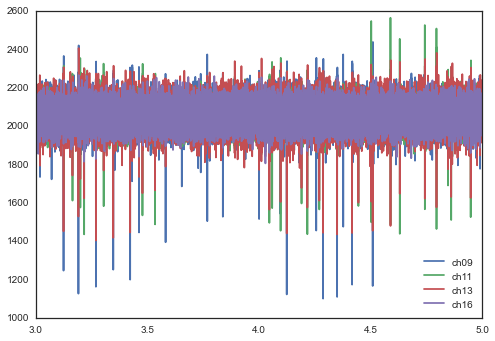

In [14]:
signals[3.:5].plot()

# Construct catalogue - step 1 filter and smooth

The class SignalFilter help:
  * high pass filter
  * smooth with boxcar

Locust dataset is already high pass filtered at 300Hz. So no need to filter again.
But to avoid peak detection problem we apply some smoothing with box of size 5.

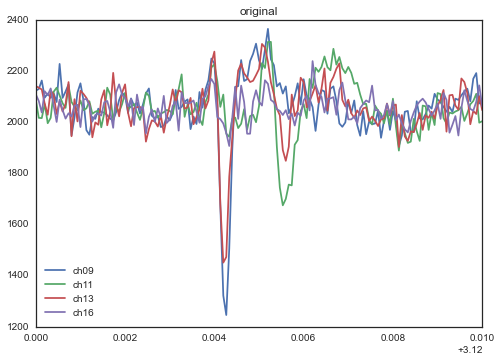

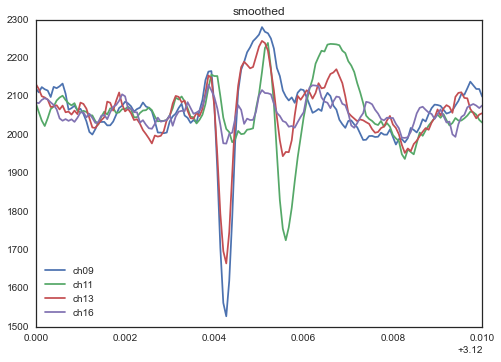

In [22]:
filter =  tdc.SignalFilter(signals, highpass_freq = 0., box_smooth = 5)
filtered_sigs = filter.get_filtered_data()

signals[3.12:3.13].plot(title = 'original')
filtered_sigs[3.12:3.13].plot(title = 'smoothed')



# Construct catalogue - step 2 peak detection

The class PeakDetector help for detecting peaks with the recipes:
  1. It norm the signals so that all channel have median=0 and mad=1
  2. rectify the signals : all sample under/above threhold are set to zeros.
  3. sum all rectified signal for all channels
  4. find peaks that are above/below there neigboors (=n_span)




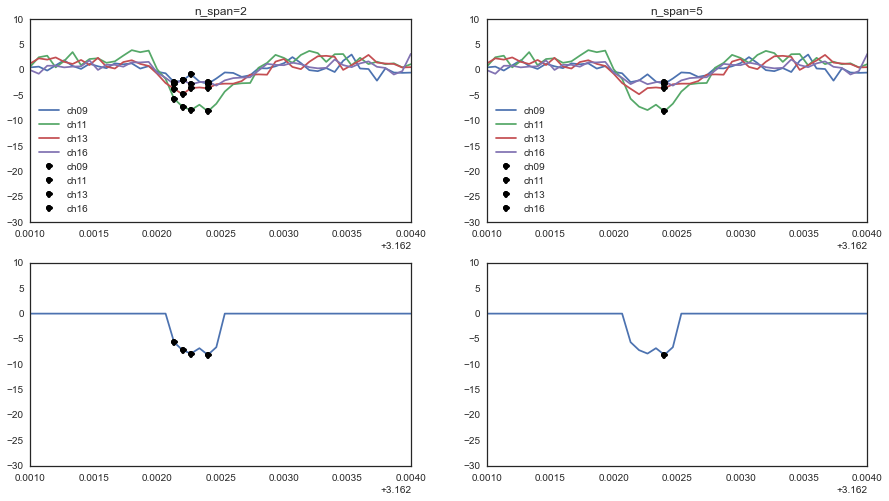

In [30]:
peakdetector = tdc.PeakDetector(signals)
peaks_pos_bad = peakdetector.detect_peaks(threshold=-5, peak_sign = '-', n_span = 1)
peaks_index_bad = signals.index[peaks_pos_bad]

peaks_pos_ok = peakdetector.detect_peaks(threshold=-5, peak_sign = '-', n_span = 15)
peaks_index_ok = signals.index[peaks_pos_ok]

fig, axs = pyplot.subplots(nrows = 2, ncols = 2, figsize = (15, 8))

normed_sigs = peakdetector.normed_sigs

t1, t2 = 3.163, 3.166
chunk = peakdetector.normed_sigs[t1:t2]
chunk_rectified = peakdetector.rectified_sigs.sum(axis=1)[t1:t2]

#bad
chunk.plot(ax = axs[0,0])
chunk_rectified.plot(ax = axs[1,0])
peaks_value_bad = normed_sigs.loc[peaks_index_bad]
peaks_value_bad[t1:t2].plot(marker = 'o', linestyle = 'None', ax = axs[0,0], color = 'k')
axs[0,0].set_title('n_span=2')
peaks_value_bad = chunk_rectified.loc[peaks_index_bad]
peaks_value_bad[t1:t2].plot(marker = 'o', linestyle = 'None', ax = axs[1,0], color = 'k')



#OK
chunk.plot(ax = axs[0,1])
chunk_rectified.plot(ax = axs[1,1])
peaks_value_ok = normed_sigs.loc[peaks_index_ok]
peaks_value_ok[t1:t2].plot(marker = 'o', linestyle = 'None', ax = axs[0,1], color = 'k')
axs[0,1].set_title('n_span=5')
peaks_value_ok = chunk_rectified.loc[peaks_index_ok]
peaks_value_ok[t1:t2].plot(marker = 'o', linestyle = 'None', ax = axs[1,1], color = 'k')



for ax in axs.flatten():
    ax.set_ylim(-30, 10)

Finally we detect peak on the smoothed signals.

In [32]:
peakdetector = tdc.PeakDetector(signals)
peaks_pos = peakdetector.detect_peaks(threshold=-3, peak_sign = '-', n_span = 15)
peaks_pos

array([    43,     87,    254, ..., 430675, 431380, 431498])

# Construct catalogue - step 3 extract waveform and find good limits.

The class WaveformExtractor offers facilities to:
    * extreact waveforms
    * extract noise (=fake waveform in between peaks)
    * keep or exclude good events
    * find good limits for the cut.

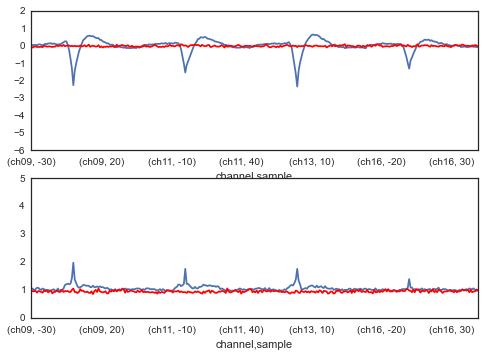

In [33]:
#start with larger sweep
waveformextractor = tdc.WaveformExtractor(peakdetector, n_left=-30, n_right=50)
med, mad = tdc.median_mad(waveformextractor.long_waveforms)
fig, axs = pyplot.subplots(nrows =2)
med.plot(ax = axs[0], ylim = (-6, 2))
mad.plot(ax = axs[1], ylim = (0, 5))

# make some noise to compare
noise = waveformextractor.extract_noise(-30, 50, size=1000, safety_factor=2)
med_noise, mad_noise = tdc.median_mad(noise)
med_noise.plot(ax = axs[0], ylim = (-6, 2), color = 'r')
mad_noise.plot(ax = axs[1], ylim = (0, 5), color = 'r')

-7 25


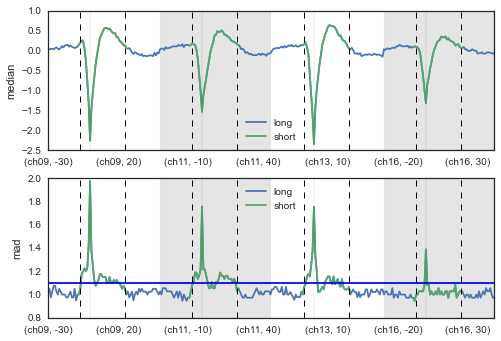

In [36]:
#find the good limits
limit_left, limit_right = waveformextractor.find_good_limits(mad_threshold = 1.1)
print(limit_left, limit_right)
waveformextractor.plot_good_limit()
short_wf = waveformextractor.get_ajusted_waveforms()

# Construct catalogue - step 4 Projection and Clustering




The class Clustering offers facilities to:
  * project waveform with : PCA, ...
  * clusters them with kmeans, EM+GMM


/usr/lib/python3/dist-packages/matplotlib/axes/_axes.py:476: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


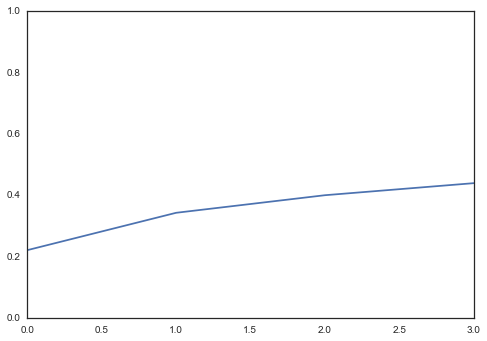

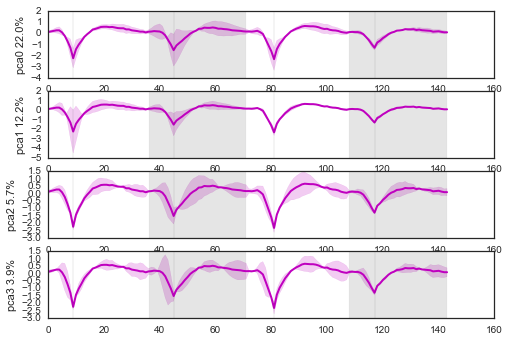

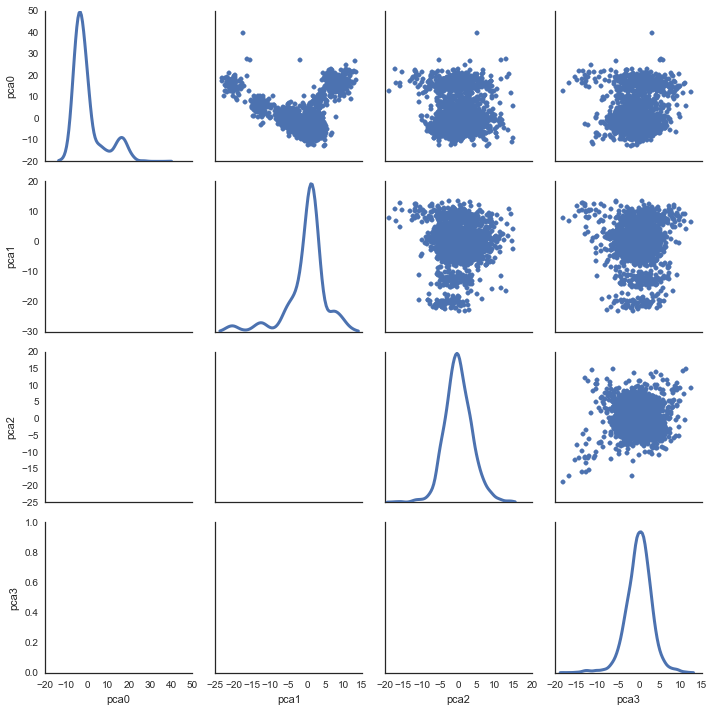

In [35]:
# work on shorted waveforms (see good limits)
clustering = tdc.Clustering(short_wf)

# do a PCA
features = clustering.project(method = 'pca', n_components = 4)
features

clustering.plot_explained_variance_ratio()
clustering.plot_waveform_variance()

clustering.plot_projection(plot_density = False)

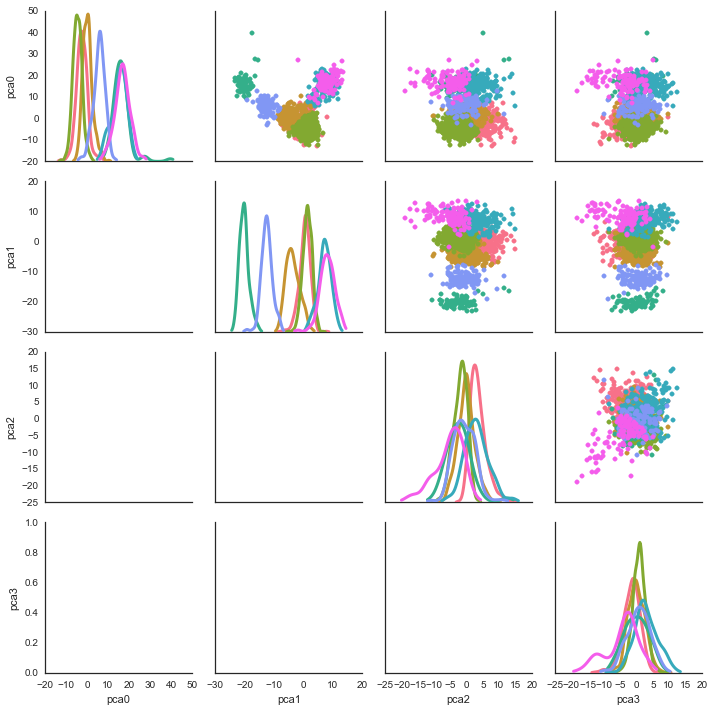

In [37]:
# try to clusters
labels = clustering.find_clusters(7)
df = pd.concat([features, labels], axis=1)

clustering.plot_projection(plot_density = False)

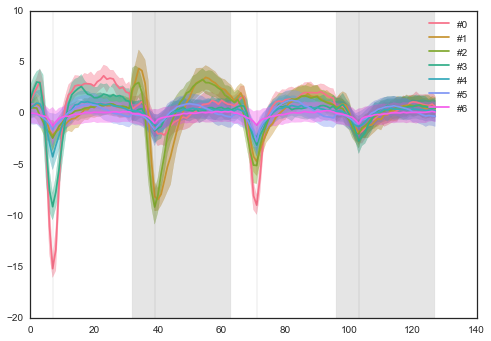

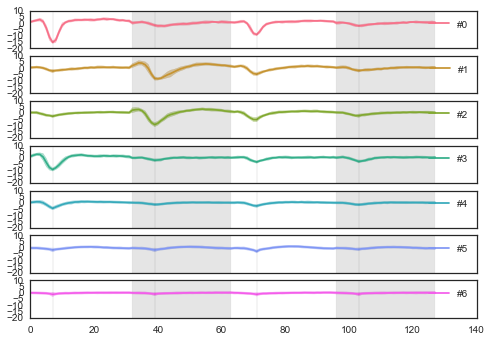

In [38]:
catalogue = clustering.construct_catalogue()
clustering.plot_catalogue(sameax = True)
clustering.plot_catalogue(sameax = False)


# interactive windows

This work only on a localhost when PyQt4+pyqtgraph is installed.

Do not forget the %gui qt4

In [39]:
%gui qt4
import pyqtgraph as pg
app = pg.mkQApp()
win = tdc.CatalogueWindow.from_classes(peakdetector, waveformextractor, clustering)
win.show()

/home/sgarcia/Documents/projet/tridesclous/tridesclous/dataio.py:132: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  self.flush_info()
/home/sgarcia/Documents/projet/tridesclous/tridesclous/dataio.py:175: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  self.flush_info()


Create DataIO :  test_tri_des_clous_mercredi, 06. janvier 2016 08h09m02


# Peeler
The class peeler help:
   * estimate jitter
   * predict spiketrain
   * subtract and get reisuals


Apply level= 0


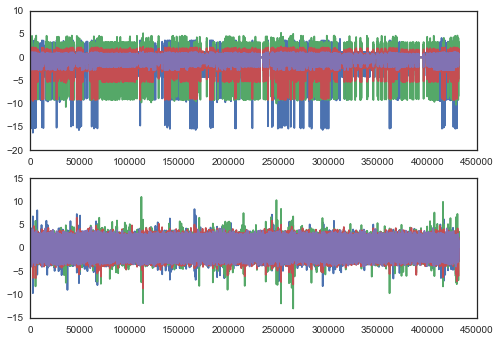

In [40]:
signals = peakdetector.normed_sigs
peeler = tdc.Peeler(signals, catalogue,  limit_left, limit_right,
                        threshold=-4, peak_sign = '-', n_span = 5)

#Peel at level=0
prediction0, residuals0 = peeler.peel()
fig, axs = pyplot.subplots(nrows = 2)
axs[0].plot(prediction0)
axs[1].plot(residuals0)



Apply level= 1


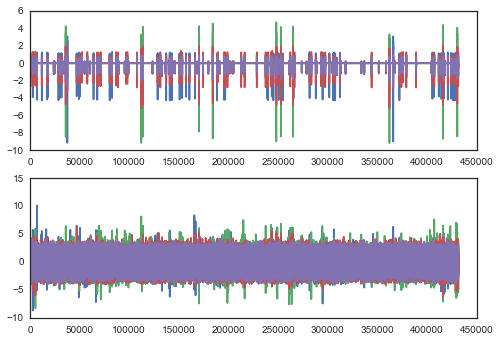

In [41]:
#Peel at level=1
prediction1, residuals1 = peeler.peel()
fig, axs = pyplot.subplots(nrows = 2)
axs[0].plot(prediction1)
axs[1].plot(residuals1)


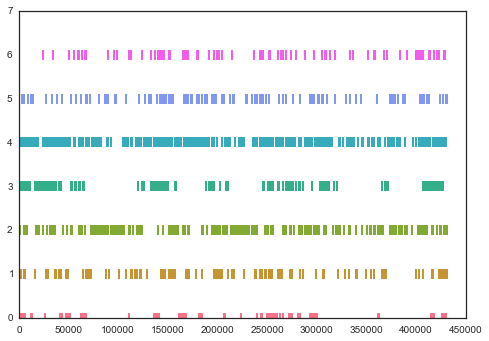

In [42]:
peeler.plot_spiketrains()